In [1]:
import sys
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
# plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 18,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )
# mpl.rcParams.update(
#     {'font.size': 18,
#      'font.family': 'sans-serif',
#      'font.sans-serif': ['Helvetica'],
#      'legend.fontsize': 14,
#      'axes.labelsize': 18,
#      'xtick.labelsize': 14,
#      'ytick.labelsize': 14
#     }
#     )
mpl.rcParams

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-e1651/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/extensions', '/scratch/malvesga/.ipyth

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

# norm_to_1fb = True
norm_to_1fb = False

#lepton_type = 'muon'
lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = True

bkg_MC_mix_protons = True

# run_tables = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


### Event selection

In [3]:
def tau21_ddt_calculation(df, label_jet=None):
    
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    jet0_tau21_ = ( df.loc[ :, "jet0_tau2"] / df.loc[ :, "jet0_tau1"] )
    
    rhoprime1_ = np.log((((df.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df.loc[ :, "jet0_pt" + label_jet_])))
    M_ = -0.055114753311384504 ##M is the slope of the tau21 versus rhoprime1
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    return jet0_tau21_, rhoprime1_, jet0_tau21_ddt_

In [4]:
def select_events( df_events, lepton_type, max_num_tracks = 4, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
    deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )
    
    rhoprime1_ = np.log((((df_events.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df_events.loc[ :, "jet0_pt" + label_jet_])))
    M_ = -0.055114753311384504 ##M is the slope of the tau21 versus rhoprime1
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
#     msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
#                  ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    if lepton_type == 'muon':
        msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    elif lepton_type == 'electron':
        msk_met_ = ( df_events.loc[ :, "met"] >= 100.0 )    
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )

    #### sideband studies 
    ##msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
    ##                     ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )

    ##msk_tau21_       = ( jet0_tau21_ddt_ <= 0.7 )
    ##msk_tau21_       = ( jet0_tau21_ <= 0.6 )
    
    ####
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
    
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )
    
    ##masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
    ##           msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
    ##           msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    
    masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    ##selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
    ##                    "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
    ##                    "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    
    selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [5]:
load_signal = True

labels_signals = []
if data_sample == '2017':
    if lepton_type == 'muon':
#         labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]
#         labels_signals = [ "GGToWW-AQGC-muon-A0W1e-6", "GGToWW-AQGC-muon-A0W2e-6", "GGToWW-AQGC-muon-A0W5e-6" ]
        labels_signals = [ "GGToWW-AQGC-2017-muon-A0W1e-6", "GGToWW-AQGC-2017-muon-A0W2e-6", "GGToWW-AQGC-2017-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
#         labels_signals = [ "GGToWW-AQGC-electron-A0W1e-6", "GGToWW-AQGC-electron-A0W2e-6", "GGToWW-AQGC-electron-A0W5e-6" ]
        labels_signals = [ "GGToWW-AQGC-2017-electron-A0W1e-6", "GGToWW-AQGC-2017-electron-A0W2e-6", "GGToWW-AQGC-2017-electron-A0W5e-6" ]
elif data_sample == '2018':
    if lepton_type == 'muon':
#         labels_signals = [ "GGToWW-AQGC-2018-muon-A0W5e-7", "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6" ]
        labels_signals = [ "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
#         labels_signals = [ "GGToWW-AQGC-2018-electron-A0W5e-7", "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6" ]
        labels_signals = [ "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6" ]
    
df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}
df_signals_protons_multiRP_events_nTracks40 = {}
df_signals_protons_multiRP_pre_sel_events = {}
if load_signal:
    base_path_ = "output"
    for label_ in labels_signals:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )           
            df_counts_signals[ label_ ] = store_[ "counts" ]
            df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
            df_signals_protons_multiRP_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_signals__ = df_signals_protons_multiRP_pre_sel_events[ label_ ]
            M_ = -0.055114753311384504
            df_signals__["jet0_tau21_ddt"] = ( df_signals__.loc[ :, "jet0_tau2"] / df_signals__.loc[ :, "jet0_tau1"] ) - (M_*(np.log((((df_signals__.loc[ :, "jet0_corrmass" + "_nom"])**2)/(df_signals__.loc[ :, "jet0_pt" + "_nom"])))))          
            print ( df_signals__.shape[0] )
            
            df_signals_protons_multiRP_events__, selection_keys__, selections__ = select_events( df_signals__, lepton_type )
            print ( df_signals_protons_multiRP_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events[ label_ ] = {}
            df_signals_protons_multiRP_events[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events__
            
            df_signals_protons_multiRP_events_nTracks40__, selection_keys__, selections__ = select_events( df_signals__, lepton_type, max_num_tracks=40 )
            print ( df_signals_protons_multiRP_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events_nTracks40[ label_ ] = {}
            df_signals_protons_multiRP_events_nTracks40[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events_nTracks40__

GGToWW-AQGC-2018-electron-A0W1e-6
['/counts', '/events_multiRP', '/protons_multiRP']
618
251
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 618, 'Electron': 618, 'Jet': 549, 'Jet_Electron': 549, 'MET': 376, 'Jet_MET': 374, 'BJet_Veto': 374, 'Xi_CMS': 371, 'WLeptonic': 368, 'Jet_WLeptonic': 368, 'MWW': 367, 'ExtraTracks': 251}
363
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 618, 'Electron': 618, 'Jet': 549, 'Jet_Electron': 549, 'MET': 376, 'Jet_MET': 374, 'BJet_Veto': 374, 'Xi_CMS': 371, 'WLeptonic': 368, 'Jet_WLeptonic': 368, 'MWW': 367, 'ExtraTracks': 363}
GGToWW-AQGC-2018-electron-A0W2e-6
['/counts', '/events_multiRP', '/protons_multiRP']
1010
475
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1

In [6]:
# df_signals_protons_multiRP_events[ 'GGToWW-AQGC-2017-muon-A0W1e-6' ]
# df_signals_protons_multiRP_index[ 'GGToWW-AQGC-2018-muon-A0W1e-6' ].columns.values
# df_signals_protons_multiRP_index[ 'GGToWW-AQGC-2018-muon-A0W1e-6' ][ ['pileupWeight','xi','random','arm','ismultirp', 'eff_proton_all'] ]
# df_signals_protons_multiRP_events[ 'GGToWW-AQGC-2018-muon-A0W1e-6' ]
# df_signals_protons_multiRP_events[ 'GGToWW-AQGC-2018-electron-A0W5e-7' ]
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2017-muon-A0W2e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2017-electron-A0W2e-6'
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2018-muon-A0W1e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2018-electron-A0W1e-6'
df_signals_protons_multiRP_events[ label_ref_ ]

{'_nom':                                                 crossingAngle  betaStar  \
 run lumiblock event hash_id              slice                            
 1   62        612   1815521296983520992  0              144.0       0.4   
     131       1310  13385357435107877852 0              130.0       0.4   
     134       1333  5215443731372031985  0              130.0       0.4   
     1055      10544 13928834882585833765 0              154.0       0.4   
     1075      10743 18381440786161119523 0              130.0       0.4   
 ...                                                       ...       ...   
     9705      97049 14417324864221269660 0              130.0       0.4   
     9736      97360 8816305026492762740  0              138.0       0.4   
     9880      98794 5249756786376693243  0              148.0       0.4   
     9959      99581 1096076079944316008  0              133.0       0.4   
     9989      99888 14368869497932049563 0              149.0       0.4   
 
  

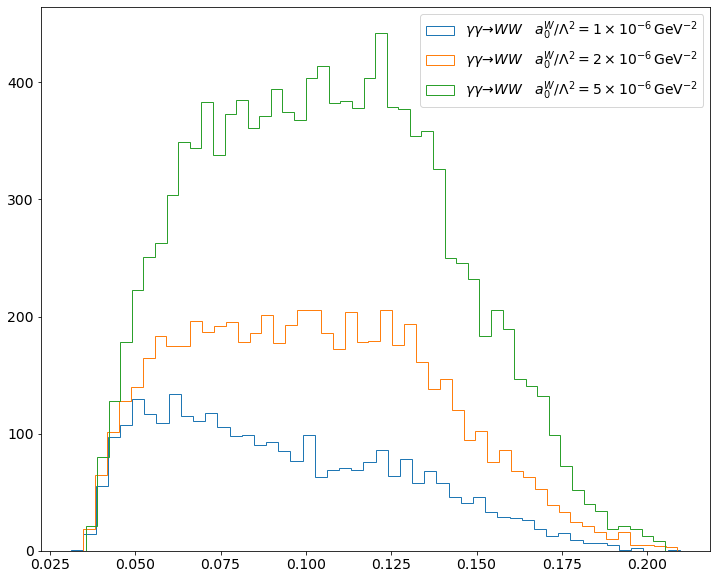

In [7]:
labels_samples = {
    "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$"
}
labels_samples[ "GGToWW-AQGC-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]

if load_signal:
    fig = plt.figure( figsize=(12,10) )
    for label_ in labels_signals: 
        plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
    plt.legend( loc='best', fontsize=14 )

In [8]:
import json
samples_info = None
if data_sample == '2017':
    samples_info = json.load( open( 'samples_info_2017.json' ) )
elif data_sample == '2018':
#     samples_info = json.load( open( 'samples_info_2018.json' ) )
#     samples_info = json.load( open( 'samples_info_UL.json' ) )
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [100000.0, 0.045393, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [100000.0, 0.058313, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [100000.0, 0.148122, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [99000.0, 0.16477, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [100000.0, 0.049199, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_8e-6_semi_pt0': [100000.0, 0.061404, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 0.0409705, 1.0, 6],
 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8': [200205760.0, 831.76, 1.0, 800],
 'WW_TuneCP5_13TeV-pythia8': [6013000.0, 75.95, 1.0, 800],
 'WZ_TuneCP5_13TeV-pythia8': [6017000.0, 27.59, 1.0, 800],
 'ZZ_TuneCP5_13TeV-pythia8': [3000.0, 12.17, 1.0, 800],
 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8': [7654000.0,
  3.549,
  1.0,
  800],
 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8': [178756000.0,
  115.3,
  1.0,
  800],
 'ST

In [9]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
if data_sample == '2017':
#     sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-muon-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-muon-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-muon-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-electron-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-electron-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
#     sample_names[ "GGToWW-AQGC-electron-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
elif data_sample == '2018':
#     sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = "GGToWW_bSM-A0W5e-7_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = "GGToWW_bSM-A0W5e-7_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6-2018"
#     sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = ""
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
#     sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = ""
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    
norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    print ( samples_info[ sample_names[ label_ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label_ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
    if norm_to_1fb:
        sample_cross_section_ = 1.e-03
#     if data_sample == '2018':
#         sample_cross_section_ *= ( 0.14271*(1.174) )
    print ( sample_cross_section_ )
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
#     df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

58.85237825936951
GGToWW-AQGC-2018-electron-A0W1e-6
[100000.0, 0.045393, 1.0, 6]
0.045393
[5.88523783e-04 4.53930000e+01 1.00000000e+00]
GGToWW-AQGC-2018-electron-A0W2e-6
[100000.0, 0.058313, 1.0, 6]
0.058313
[5.88523783e-04 5.83130000e+01 1.00000000e+00]
GGToWW-AQGC-2018-electron-A0W5e-6
[100000.0, 0.148122, 1.0, 6]
0.148122
[5.88523783e-04 1.48122000e+02 1.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Background

### Load and select events

In [10]:
##criar flag para usar bkg assim ou da MC+mix_protons

# ['crossingAngle', 'betaStar', 'instLumi', 'jet0_pt', 'jet0_eta',
#        'jet0_phi', 'jet0_energy', 'jet0_mass', 'jet0_corrmass',
#        'jet0_tau1', 'jet0_tau2', 'jet0_vertexz', 'jet0_px', 'jet0_py',
#        'jet0_pz', 'calo_met', 'met', 'met_x', 'met_y', 'met_phi',
#        'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4',
#        'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad',
#        'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt',
#        'WLeptonicEta', 'WLeptonicPhi', 'muon0_pt', 'muon0_eta',
#        'muon0_phi', 'muon0_energy', 'muon0_charge', 'muon0_iso',
#        'muon0_dxy', 'muon0_dz', 'muon0_trackerLayersWithMeasurement',
#        'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd',
#        'betaStar_rnd', 'period', 'jet0_pt_nom', 'jet0_energy_nom',
#        'jet0_mass_nom', 'jet0_corrmass_nom', 'jet0_px_nom', 'jet0_py_nom',
#        'jet0_pz_nom', 'muon0_pt_nom', 'muon0_energy_nom', 'muon0_px_nom',
#        'muon0_py_nom', 'muon0_pz_nom', 'WLeptonicPt_nom',
#        'WLeptonicPx_nom', 'WLeptonicPy_nom', 'WLeptonicPz_nom',
#        'WLeptonicE_nom', 'WLeptonicM_nom', 'WW_energy_nom', 'WW_pz_nom',
#        'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
#        'within_aperture', 'xlow', 'xhigh', 'ylow', 'yhigh', 'MX', 'YX',
#        'diffMWW_MX', 'ratioMWW_MX', 'shiftedRatioMWW_MX', 'diffYWW_YX',
#        'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']

In [11]:
# resample_factor = 20
# resample_factor = 50

# label = "data-random-resample_20"
# label = "data-random-resample_50-single-arm"

if not bkg_MC_mix_protons: 
    labels_background = []
    fileNames_bkg = {}
    resample_factor = 50
    if data_sample == '2017':
        if lepton_type == 'muon':
            labels_background = [
                "data-random-resample_50-single-arm-muon-2017B",
                "data-random-resample_50-single-arm-muon-2017C",
                "data-random-resample_50-single-arm-muon-2017D",
                "data-random-resample_50-single-arm-muon-2017E",
                "data-random-resample_50-single-arm-muon-2017F"
            ]
            fileNames_bkg = {
                "data-random-resample_50-single-arm-muon-2017B": "data-store-data-random-resample_50-single-arm-2017B.h5",
                "data-random-resample_50-single-arm-muon-2017C": "data-store-data-random-resample_50-single-arm-2017C.h5",
                "data-random-resample_50-single-arm-muon-2017D": "data-store-data-random-resample_50-single-arm-2017D.h5",
                "data-random-resample_50-single-arm-muon-2017E": "data-store-data-random-resample_50-single-arm-2017E.h5",
                "data-random-resample_50-single-arm-muon-2017F": "data-store-data-random-resample_50-single-arm-2017F.h5"
            }
        elif lepton_type == 'electron':
            labels_background = [
                "data-random-resample_50-single-arm-electron-2017B",
                "data-random-resample_50-single-arm-electron-2017C",
                "data-random-resample_50-single-arm-electron-2017D",
                "data-random-resample_50-single-arm-electron-2017E",
                "data-random-resample_50-single-arm-electron-2017F"
            ]
            fileNames_bkg = {
                "data-random-resample_50-single-arm-electron-2017B": "data-store-data-random-resample_50-single-arm-electron-2017B.h5",
                "data-random-resample_50-single-arm-electron-2017C": "data-store-data-random-resample_50-single-arm-electron-2017C.h5",
                "data-random-resample_50-single-arm-electron-2017D": "data-store-data-random-resample_50-single-arm-electron-2017D.h5",
                "data-random-resample_50-single-arm-electron-2017E": "data-store-data-random-resample_50-single-arm-electron-2017E.h5",
                "data-random-resample_50-single-arm-electron-2017F": "data-store-data-random-resample_50-single-arm-electron-2017F.h5"
            }
    elif data_sample == '2018':
        if lepton_type == 'muon':
            labels_background = [
                "data-random-resample_50-2018-muon-2018A",
                "data-random-resample_50-2018-muon-2018B",
                "data-random-resample_50-2018-muon-2018C",
                #"data-random-resample_50-2018-muon-2018D",
                "data-random-resample_50-2018-muon-2018D-1",
                "data-random-resample_50-2018-muon-2018D-2",
                "data-random-resample_50-2018-muon-2018D-3",
                "data-random-resample_50-2018-muon-2018D-4",
                "data-random-resample_50-2018-muon-2018D-5",
                "data-random-resample_50-2018-muon-2018D-6"
            ]
            fileNames_bkg = {
                "data-random-resample_50-2018-muon-2018A": "data-store-data-random-resample_50-2018-muon-2018A.h5",
                "data-random-resample_50-2018-muon-2018B": "data-store-data-random-resample_50-2018-muon-2018B.h5",
                "data-random-resample_50-2018-muon-2018C": "data-store-data-random-resample_50-2018-muon-2018C.h5",
                #"data-random-resample_50-2018-muon-2018D": "data-store-data-random-resample_50-2018-muon-2018D.h5",
                "data-random-resample_50-2018-muon-2018D-1": "data-store-data-random-resample_50-2018-muon-2018D-1.h5",
                "data-random-resample_50-2018-muon-2018D-2": "data-store-data-random-resample_50-2018-muon-2018D-2.h5",
                "data-random-resample_50-2018-muon-2018D-3": "data-store-data-random-resample_50-2018-muon-2018D-3.h5",
                "data-random-resample_50-2018-muon-2018D-4": "data-store-data-random-resample_50-2018-muon-2018D-4.h5",
                "data-random-resample_50-2018-muon-2018D-5": "data-store-data-random-resample_50-2018-muon-2018D-5.h5",
                "data-random-resample_50-2018-muon-2018D-6": "data-store-data-random-resample_50-2018-muon-2018D-6.h5"
            }             
        elif lepton_type == 'electron':
            labels_background = [
                "data-random-resample_50-2018-electron-2018A",
                "data-random-resample_50-2018-electron-2018B",
                "data-random-resample_50-2018-electron-2018C",
                #"data-random-resample_50-2018-electron-2018D",
                "data-random-resample_50-2018-electron-2018D-1",
                "data-random-resample_50-2018-electron-2018D-2",
                "data-random-resample_50-2018-electron-2018D-3",
                "data-random-resample_50-2018-electron-2018D-4",
                "data-random-resample_50-2018-electron-2018D-5",
                "data-random-resample_50-2018-electron-2018D-6"
            ]
            fileNames_bkg = {
                "data-random-resample_50-2018-electron-2018A": "data-store-data-random-resample_50-2018-electron-2018A.h5",
                "data-random-resample_50-2018-electron-2018B": "data-store-data-random-resample_50-2018-electron-2018B.h5",
                "data-random-resample_50-2018-electron-2018C": "data-store-data-random-resample_50-2018-electron-2018C.h5",
                #"data-random-resample_50-2018-electron-2018D": "data-store-data-random-resample_50-2018-electron-2018D.h5",
                "data-random-resample_50-2018-electron-2018D-1": "data-store-data-random-resample_50-2018-electron-2018D-1.h5",
                "data-random-resample_50-2018-electron-2018D-2": "data-store-data-random-resample_50-2018-electron-2018D-2.h5",
                "data-random-resample_50-2018-electron-2018D-3": "data-store-data-random-resample_50-2018-electron-2018D-3.h5",
                "data-random-resample_50-2018-electron-2018D-4": "data-store-data-random-resample_50-2018-electron-2018D-4.h5",
                "data-random-resample_50-2018-electron-2018D-5": "data-store-data-random-resample_50-2018-electron-2018D-5.h5",
                "data-random-resample_50-2018-electron-2018D-6": "data-store-data-random-resample_50-2018-electron-2018D-6.h5"
            }

    
    base_path_ = "output"
    for label_ in fileNames_bkg:
        fileNames_bkg[ label_ ] = "{}/{}".format( base_path_, fileNames_bkg[ label_ ] )
    print ( fileNames_bkg )

    # file_path_ = "{}/data-store-{}.h5".format( base_path_, label )
    # print ( file_path_ )

    df_counts_bkg = None
    # df_protons_multiRP_bkg_index = None
    df_protons_multiRP_bkg_events = None
    df_protons_multiRP_bkg_events_nTracks40 = None

    df_counts_bkg_list_ = []
    # df_protons_multiRP_bkg_index_list_ = []
    df_protons_multiRP_bkg_events_list_ = []
    df_protons_multiRP_bkg_events_list_nTracks40_ = []
    for label_ in labels_background:
        print ( label_ )
        file_path_ = fileNames_bkg[ label_ ]
        print ( file_path_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            
            df_counts_bkg__ = store_[ "counts" ]
    #         df_protons_multiRP_bkg_index__  = store_[ "protons_multiRP" ]
            df_protons_multiRP_bkg_events__ = store_[ "events_multiRP" ]
            if lepton_type == 'muon':
                df_protons_multiRP_bkg_events__ = df_protons_multiRP_bkg_events__.loc[ :, 
                    ['crossingAngle',
                     'jet0_eta', 'jet0_phi', 
                     'jet0_tau1', 'jet0_tau2',
                     'met', 'met_phi',
                     'num_bjets_ak4',
                     'pfcand_nextracks', 'pfcand_nextracks_noDRl',
                     'WLeptonicEta', 'WLeptonicPhi',
                     'muon0_eta', 'muon0_phi', 'muon0_iso',
                     'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd', 'period',
                     'jet0_pt_nom', 'jet0_energy_nom', 'jet0_corrmass_nom',
                     'muon0_pt_nom', 
                     'WLeptonicPt_nom', 
                     'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
                     'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']
                ]
            if lepton_type == 'electron':
                df_protons_multiRP_bkg_events__ = df_protons_multiRP_bkg_events__.loc[ :, 
                    ['crossingAngle',
                     'jet0_eta', 'jet0_phi', 
                     'jet0_tau1', 'jet0_tau2',
                     'met', 'met_phi',
                     'num_bjets_ak4',
                     'pfcand_nextracks', 'pfcand_nextracks_noDRl',
                     'WLeptonicEta', 'WLeptonicPhi',
                     'electron0_eta', 'electron0_phi', #'electron0_iso',
                     'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd', 'period',
                     'jet0_pt_nom', 'jet0_energy_nom', 'jet0_corrmass_nom',
                     'electron0_pt_nom', 
                     'WLeptonicPt_nom', 
                     'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
                     'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']
                ]

            print ( df_protons_multiRP_bkg_events__.shape[0] )
            df_protons_multiRP_bkg_events_nTracks40__, selection_keys__, selections__ = select_events( df_protons_multiRP_bkg_events__, lepton_type, max_num_tracks=40 )
            print ( df_protons_multiRP_bkg_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events_def__, selection_keys__, selections__ = select_events( df_protons_multiRP_bkg_events__, lepton_type )
            print ( df_protons_multiRP_bkg_events_def__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )    
    
            df_counts_bkg_list_.append( df_counts_bkg__ )
    #         df_protons_multiRP_bkg_index_list_.append( df_protons_multiRP_bkg_index__ )
    #         df_protons_multiRP_bkg_events_list_.append( df_protons_multiRP_bkg_events__ )
            df_protons_multiRP_bkg_events_list_.append( df_protons_multiRP_bkg_events_def__ )
            df_protons_multiRP_bkg_events_list_nTracks40_.append( df_protons_multiRP_bkg_events_nTracks40__ )

    df_counts_bkg = df_counts_bkg_list_[0]
    for idx_ in range( 1, len( df_counts_bkg_list_ ) ):
        df_counts_bkg = df_counts_bkg.add( df_counts_bkg_list_[ idx_ ] )

    # df_protons_multiRP_bkg_index = pd.concat( df_protons_multiRP_bkg_index_list_ )
    df_protons_multiRP_bkg_events = pd.concat( df_protons_multiRP_bkg_events_list_ )
    df_protons_multiRP_bkg_events_nTracks40 = pd.concat( df_protons_multiRP_bkg_events_list_nTracks40_ )

In [12]:
if bkg_MC_mix_protons:
    labels_background = []
    fileNames_bkg = {}
    resample_factor = 1
    if data_sample == '2017':
        if lepton_type == 'muon':
            labels_background = [ "GGToWW-AQGC-mix_protons-2017-muon-A0W1e-6", "GGToWW-AQGC-mix_protons-2017-muon-A0W2e-6", "GGToWW-AQGC-mix_protons-2017-muon-A0W5e-6" ]
            fileNames_bkg = {
                "GGToWW-AQGC-mix_protons-2017-muon-A0W1e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W1e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-muon-A0W2e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W2e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-muon-A0W5e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W5e-6.h5"
            }
        elif lepton_type == 'electron':
            labels_background = [ "GGToWW-AQGC-mix_protons-2017-electron-A0W1e-6", "GGToWW-AQGC-mix_protons-2017-electron-A0W2e-6", "GGToWW-AQGC-mix_protons-2017-electron-A0W5e-6" ] 
            fileNames_bkg = {
                "GGToWW-AQGC-mix_protons-2017-electron-A0W1e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W1e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-electron-A0W2e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W2e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-electron-A0W5e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W5e-6.h5"
            }
    elif data_sample == '2018':
        if lepton_type == 'muon':
            labels_background = [ "Bkg-mix_protons-2018-muon-TTJets", "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J", "Bkg-mix_protons-2018-muon-DYJetsToLL_0J", "Bkg-mix_protons-2018-muon-DYJetsToLL_1J", "Bkg-mix_protons-2018-muon-DYJetsToLL_2J", "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600", "Bkg-mix_protons-2018-muon-QCD_Pt_600to800", "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-WW", "Bkg-mix_protons-2018-muon-ZZ"]
            #labels_background = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_2J", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600", "Bkg-mix_protons-2018-muon-QCD_Pt_600to800", "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ] 
            fileNames_bkg = {
                "Bkg-mix_protons-2018-muon-TTJets": "output-Bkg-mix_protons-2018-muon-TTJets.h5",
                #"Bkg-mix_protons-2018-muon-WJetsToLNu_0J": "output-Bkg-mix_protons-2018-muon-WJetsToLNu_0J.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_1J": "output-Bkg-mix_protons-2018-muon-WJetsToLNu_1J.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_2J": "output-Bkg-mix_protons-2018-muon-WJetsToLNu_2J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_0J": "output-Bkg-mix_protons-2018-muon-DYJetsToLL_0J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_1J": "output-Bkg-mix_protons-2018-muon-DYJetsToLL_1J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_2J": "output-Bkg-mix_protons-2018-muon-DYJetsToLL_2J.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_170to300": "output-Bkg-mix_protons-2018-muon-QCD_Pt_170to300.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_300to470": "output-Bkg-mix_protons-2018-muon-QCD_Pt_300to470.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_470to600": "output-Bkg-mix_protons-2018-muon-QCD_Pt_470to600.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_600to800": "output-Bkg-mix_protons-2018-muon-QCD_Pt_600to800.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000": "output-Bkg-mix_protons-2018-muon-QCD_Pt_800to1000.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400": "output-Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800": "output-Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400": "output-Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400.h5",
                "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays": "output-Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": "output-Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays": "output-Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays": "output-Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays": "output-Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-WW": "output-Bkg-mix_protons-2018-muon-WW.h5",
                "Bkg-mix_protons-2018-muon-ZZ": "output-Bkg-mix_protons-2018-muon-ZZ.h5"
            }
  
        elif lepton_type == 'electron':
            labels_background = [ "Bkg-mix_protons-2018-electron-TTJets", "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J", "Bkg-mix_protons-2018-electron-DYJetsToLL_0J", "Bkg-mix_protons-2018-electron-DYJetsToLL_1J", "Bkg-mix_protons-2018-electron-DYJetsToLL_2J", "Bkg-mix_protons-2018-electron-QCD_Pt_170to300", "Bkg-mix_protons-2018-electron-QCD_Pt_300to470", "Bkg-mix_protons-2018-electron-QCD_Pt_470to600", "Bkg-mix_protons-2018-electron-QCD_Pt_600to800", "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000", "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf", "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-WW", "Bkg-mix_protons-2018-electron-ZZ" ]
            fileNames_bkg = {
                "Bkg-mix_protons-2018-electron-TTJets": "output-Bkg-mix_protons-2018-electron-TTJets.h5",
                #"Bkg-mix_protons-2018-electron-WJetsToLNu_0J": "output-Bkg-mix_protons-2018-electron-WJetsToLNu_0J.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_1J": "output-Bkg-mix_protons-2018-electron-WJetsToLNu_1J.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_2J": "output-Bkg-mix_protons-2018-electron-WJetsToLNu_2J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_0J": "output-Bkg-mix_protons-2018-electron-DYJetsToLL_0J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_1J": "output-Bkg-mix_protons-2018-electron-DYJetsToLL_1J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_2J": "output-Bkg-mix_protons-2018-electron-DYJetsToLL_2J.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_170to300": "output-Bkg-mix_protons-2018-electron-QCD_Pt_170to300.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_300to470": "output-Bkg-mix_protons-2018-electron-QCD_Pt_300to470.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_470to600": "output-Bkg-mix_protons-2018-electron-QCD_Pt_470to600.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_600to800": "output-Bkg-mix_protons-2018-electron-QCD_Pt_600to800.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000": "output-Bkg-mix_protons-2018-electron-QCD_Pt_800to1000.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400": "output-Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800": "output-Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400": "output-Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200": "output-Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf": "output-Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf.h5",
                "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays": "output-Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": "output-Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays": "output-Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays": "output-Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays": "output-Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-WW": "output-Bkg-mix_protons-2018-electron-WW.h5",
                "Bkg-mix_protons-2018-electron-ZZ": "output-Bkg-mix_protons-2018-electron-ZZ.h5"
    
            }

    df_counts_bkg = {}
    df_protons_multiRP_bkg_index = {}
    df_protons_multiRP_bkg_pre_sel_events = {}
    df_protons_multiRP_bkg_events = {}
    df_protons_multiRP_bkg_events_nTracks40 = {}
    
    base_path_ = "output"
    for label_ in labels_background:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_bkg[ label_ ] = store_[ "counts" ]
            df_protons_multiRP_bkg_index[ label_ ] = store_[ "protons_multiRP" ]
            df_protons_multiRP_bkg_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_bkg__ = df_protons_multiRP_bkg_pre_sel_events[ label_ ]
            M_ = -0.055114753311384504
            df_bkg__["jet0_tau21_ddt"] = ( df_bkg__.loc[ :, "jet0_tau2"] / df_bkg__.loc[ :, "jet0_tau1"] ) - (M_*(np.log((((df_bkg__.loc[ :, "jet0_corrmass" + "_nom"])**2)/(df_bkg__.loc[ :, "jet0_pt" + "_nom"])))))          
            print ( df_bkg__.shape[0] )
            
            df_protons_multiRP_bkg_events__, selection_keys__, selections__ = select_events( df_bkg__, lepton_type )
            print ( df_protons_multiRP_bkg_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events[ label_ ] = {}
            df_protons_multiRP_bkg_events[ label_ ][ "_nom" ] = df_protons_multiRP_bkg_events__
            
            df_protons_multiRP_bkg_events_nTracks40__, selection_keys__, selections__ = select_events( df_bkg__, lepton_type, max_num_tracks=40 )
            print ( df_protons_multiRP_bkg_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events_nTracks40[ label_ ] = {}
            df_protons_multiRP_bkg_events_nTracks40[ label_ ][ "_nom" ] = df_protons_multiRP_bkg_events_nTracks40__

Bkg-mix_protons-2018-electron-TTJets
['/counts', '/events_multiRP', '/protons_multiRP']


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


499852
145
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 499852, 'Electron': 499626, 'Jet': 388730, 'Jet_Electron': 379796, 'MET': 178965, 'Jet_MET': 169603, 'BJet_Veto': 96162, 'Xi_CMS': 85246, 'WLeptonic': 68606, 'Jet_WLeptonic': 65595, 'MWW': 63150, 'ExtraTracks': 145}
14081
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 499852, 'Electron': 499626, 'Jet': 388730, 'Jet_Electron': 379796, 'MET': 178965, 'Jet_MET': 169603, 'BJet_Veto': 96162, 'Xi_CMS': 85246, 'WLeptonic': 68606, 'Jet_WLeptonic': 65595, 'MWW': 63150, 'ExtraTracks': 14081}
Bkg-mix_protons-2018-electron-WJetsToLNu_1J
['/counts', '/events_multiRP', '/protons_multiRP']


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


15692
28
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 15692, 'Electron': 15692, 'Jet': 10504, 'Jet_Electron': 10492, 'MET': 5806, 'Jet_MET': 5795, 'BJet_Veto': 5787, 'Xi_CMS': 4843, 'WLeptonic': 4706, 'Jet_WLeptonic': 4706, 'MWW': 4209, 'ExtraTracks': 28}
2176
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 15692, 'Electron': 15692, 'Jet': 10504, 'Jet_Electron': 10492, 'MET': 5806, 'Jet_MET': 5795, 'BJet_Veto': 5787, 'Xi_CMS': 4843, 'WLeptonic': 4706, 'Jet_WLeptonic': 4706, 'MWW': 4209, 'ExtraTracks': 2176}
Bkg-mix_protons-2018-electron-WJetsToLNu_2J
['/counts', '/events_multiRP', '/protons_multiRP']
62861
17
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 62861, 'Electron': 62861, 'Jet': 45678, 'Jet

83
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 83, 'Electron': 83, 'Jet': 83, 'Jet_Electron': 83, 'MET': 32, 'Jet_MET': 7, 'BJet_Veto': 7, 'Xi_CMS': 1, 'WLeptonic': 1, 'Jet_WLeptonic': 1, 'MWW': 1, 'ExtraTracks': 0}
1
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 83, 'Electron': 83, 'Jet': 83, 'Jet_Electron': 83, 'MET': 32, 'Jet_MET': 7, 'BJet_Veto': 7, 'Xi_CMS': 1, 'WLeptonic': 1, 'Jet_WLeptonic': 1, 'MWW': 1, 'ExtraTracks': 1}
Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400
['/counts', '/events_multiRP', '/protons_multiRP']
40
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 40, 'Electron': 40, 'Jet': 40, 'Jet_Electron': 40, 'MET': 17, 'Jet_MET': 3, 'BJet_Veto': 3, 'Xi_CMS': 0, 'WLeptonic': 0

In [13]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events)
if bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events[ label_ ][ "_nom" ])

                                                 crossingAngle  betaStar  \
run lumiblock event   hash_id             slice                            
1   1510      1509403 7641440147336475049 0              130.0       0.4   

                                                 instLumi     jet0_pt  \
run lumiblock event   hash_id             slice                         
1   1510      1509403 7641440147336475049 0           0.0  262.387848   

                                                 jet0_eta  jet0_phi  \
run lumiblock event   hash_id             slice                       
1   1510      1509403 7641440147336475049 0      1.522104  0.568707   

                                                 jet0_energy  jet0_mass  \
run lumiblock event   hash_id             slice                           
1   1510      1509403 7641440147336475049 0       631.054749  13.305438   

                                                 jet0_corrmass  jet0_tau1  \
run lumiblock event   hash_id     

In [14]:
df_counts_bkg

{'Bkg-mix_protons-2018-electron-TTJets': All                     5877626
 Jet                     5877626
 Electron                2684376
 ProtonRnd_check_none    2680721
 ProtonRnd               1823541
 dtype: int64,
 'Bkg-mix_protons-2018-electron-WJetsToLNu_1J': All                     181991
 Jet                     181991
 Electron                 84459
 ProtonRnd_check_none     84280
 ProtonRnd                57290
 dtype: int64,
 'Bkg-mix_protons-2018-electron-WJetsToLNu_2J': All                     732621
 Jet                     732621
 Electron                338718
 ProtonRnd_check_none    338068
 ProtonRnd               229988
 dtype: int64,
 'Bkg-mix_protons-2018-electron-DYJetsToLL_0J': All                     499
 Jet                     499
 Electron                327
 ProtonRnd_check_none    325
 ProtonRnd               218
 dtype: int64,
 'Bkg-mix_protons-2018-electron-DYJetsToLL_1J': All                     155369
 Jet                     155369
 Electron         

In [15]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events.columns.values)

In [16]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events_nTracks40)
if bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events_nTracks40[ label_ ][ "_nom" ])

                                                  crossingAngle  betaStar  \
run lumiblock event   hash_id              slice                            
1   1981      1980607 398578284237420280   0              130.0       0.4   
    2810      2809939 17508169508697347629 0              147.0       0.4   
    1506      1505972 13028222363338960215 0              154.0       0.4   
    3610      3609985 11730594662443003912 0              151.0       0.4   
    1182      1181733 16613043008309538590 0              154.0       0.4   
    1983      1982147 4355500530244170480  0              130.0       0.4   
    1510      1509403 7641440147336475049  0              130.0       0.4   
    346       345198  7310585869860245038  0              132.0       0.4   
    1140      1139271 4550367626889500822  0              132.0       0.4   
    1382      1381529 9287459023215181388  0              130.0       0.4   
    3007      3006164 3014128171845546322  0              148.0       0.4   

In [17]:
if not bkg_MC_mix_protons:
    norm_factors['Bkg'] = np.array( [ ( 1. / resample_factor ) ] )
    df_protons_multiRP_bkg_events_nTracks40[ "norm" ] = np.product( norm_factors['Bkg'] )
    df_protons_multiRP_bkg_events[ "norm" ] = np.product( norm_factors['Bkg'] )

In [18]:
if bkg_MC_mix_protons:
    labels_samples_bkg = {
        "Bkg-mix_protons-2018-muon-TTJets": r"$t \bar{t} + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-TTJets": r"$t \bar{t} + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu": r"$W + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu": r"$W + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD": r"QCD",
        "Bkg-mix_protons-2018-electron-QCD": r"QCD",
        "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
        "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
        "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
        "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
        "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
        "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
        "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
        "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
        "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
        "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
        "Bkg-mix_protons-2018-muon-ST": r"single top",
        "Bkg-mix_protons-2018-electron-ST": r"single top",
        "Bkg-mix_protons-2018-muon-WW": r"$WW$",
        "Bkg-mix_protons-2018-electron-WW": r"$WW$",
        "Bkg-mix_protons-2018-muon-WZ": r"$WZ$",
        "Bkg-mix_protons-2018-electron-WZ": r"$WZ$",
        "Bkg-mix_protons-2018-muon-ZZ": r"$ZZ$",
        "Bkg-mix_protons-2018-electron-ZZ": r"$ZZ$",
        "Bkg-mix_protons-2018-muon-VV": r"$VV$",
        "Bkg-mix_protons-2018-electron-VV": r"$VV$"
}

In [19]:
if bkg_MC_mix_protons:
    sample_names_bkg = {}
    if data_sample == '2017':
        pass
    elif data_sample == '2018':
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        #sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
        #sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
        #sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
        #sample_names_bkg[ "Bkg-mix_protons-2018-muon-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        #sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'      
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
        #sample_names_bkg[ "Bkg-mix_protons-2018-electron-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
        

In [20]:
if bkg_MC_mix_protons:
    lumi_periods = None
    if data_sample == '2017':
        if lepton_type == 'muon':
            lumi_periods = lumi_periods_2017[ 'muon' ]
        elif lepton_type == 'electron':
            lumi_periods = lumi_periods_2017[ 'electron' ]
    elif data_sample == '2018':
        if lepton_type == 'muon':
            lumi_periods = lumi_periods_2018[ 'muon' ]
        elif lepton_type == 'electron':
            lumi_periods = lumi_periods_2018[ 'electron' ]
    
    lumi = np.sum( list( lumi_periods.values() ) )
    print ( lumi )
    
    norm_factors = {}
    for label__ in labels_background:
        print ( label__ )
        print ( samples_info[ sample_names_bkg[ label__ ] ] )
        sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names_bkg[ label__ ] ]
        sample_cross_section_ = sample_cross_section_ * sel_eff_
#         if norm_to_1fb:
#             sample_cross_section_ = 1.e-03
        print ( sample_cross_section_ )
        norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
        print ( norm_factors[ label__ ] )
        norm_factors_product_ = np.product( norm_factors[ label__ ] )
        print ( norm_factors_product_ )
        if df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].shape[0] > 0:
            df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

        if df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].shape[0] > 0:
            df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

58.85237825936951
Bkg-mix_protons-2018-electron-TTJets
[200205760.0, 831.76, 1.0, 800]
831.76
[2.93959466e-07 8.31760000e+05 1.00000000e+00]
0.24450372527250555
Bkg-mix_protons-2018-electron-WJetsToLNu_1J
[109938200.0, 8875, 1.0, 800]
8875.0
[5.35322374e-07 8.87500000e+06 1.00000000e+00]
4.750986072647218
Bkg-mix_protons-2018-electron-WJetsToLNu_2J
[1755467.0, 3338, 1.0, 800]
3338.0
[3.35251977e-05 3.33800000e+06 1.00000000e+00]
111.90710997687533
Bkg-mix_protons-2018-electron-DYJetsToLL_0J
[49476008.0, 5129, 1.0, 800]
5129.0
[1.18951348e-06 5.12900000e+06 1.00000000e+00]
6.101014618889749
Bkg-mix_protons-2018-electron-DYJetsToLL_1J
[72888824.0, 951.5, 1.0, 800]
951.5
[8.0742664e-07 9.5150000e+05 1.0000000e+00]
0.7682664480056653
Bkg-mix_protons-2018-electron-DYJetsToLL_2J
[26444976.0, 361.4, 1.0, 800]
361.4
[2.22546537e-06 3.61400000e+05 1.00000000e+00]
0.8042831841834963
Bkg-mix_protons-2018-electron-QCD_Pt_170to300
[18642000.0, 103700, 1.0, 800]
103700.0
[3.1569777e-06 1.0370000e+08

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
df_protons_multiRP_bkg_events

{'Bkg-mix_protons-2018-electron-TTJets': {'_nom':                                                     crossingAngle  betaStar  \
  run lumiblock event     hash_id              slice                            
  1   93796     243586384 1783071830308615286  0              148.0       0.4   
      79282     205894352 9105911221561781829  0              145.0       0.4   
      241687    627658880 6099704596787506168  0              142.0       0.4   
      109206    283607776 1668897736258781001  0              149.0       0.4   
      97249     252554544 17531604378218829386 0              130.0       0.4   
  ...                                                           ...       ...   
      274574    713068480 16098603254050143038 0              139.0       0.4   
      181653    471750656 3868875582086255050  0              137.0       0.4   
      151921    394538368 13136026641342141861 0              147.0       0.4   
      280200    727677696 3647795821959542071  0             

In [22]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_WJetsToLNu = "Bkg-mix_protons-2018-muon-WJetsToLNu"
        #samples_WJetsToLNu = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_0J", "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ]
        samples_WJetsToLNu = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-mix_protons-2018-muon-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-mix_protons-2018-muon-DYJetsToLL_0J", "Bkg-mix_protons-2018-muon-DYJetsToLL_1J", "Bkg-mix_protons-2018-muon-DYJetsToLL_2J" ]
        label_QCD = "Bkg-mix_protons-2018-muon-QCD"
        #samples_QCD = [ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600",
        #                "Bkg-mix_protons-2018-muon-QCD_Pt_600to800","Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400",
        #                "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf" ]
        samples_QCD = [ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600",
                        "Bkg-mix_protons-2018-muon-QCD_Pt_600to800","Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400" ]
        label_ST = "Bkg-mix_protons-2018-muon-ST"
        samples_ST = [ "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-mix_protons-2018-muon-VV"
        #samples_VV = [ "Bkg-mix_protons-2018-muon-WW",
        #               "Bkg-mix_protons-2018-muon-WZ",
        #               "Bkg-mix_protons-2018-muon-ZZ" ]
        samples_VV = [ "Bkg-mix_protons-2018-muon-WW",
                       "Bkg-mix_protons-2018-muon-ZZ" ]
    elif lepton_type == 'electron':
        label_WJetsToLNu = "Bkg-mix_protons-2018-electron-WJetsToLNu"
        #samples_WJetsToLNu = [ "Bkg-mix_protons-2018-electron-WJetsToLNu_0J", "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ]
        samples_WJetsToLNu = [ "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ]        
        label_DYJetsToLL = "Bkg-mix_protons-2018-electron-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-mix_protons-2018-electron-DYJetsToLL_0J", "Bkg-mix_protons-2018-electron-DYJetsToLL_1J", "Bkg-mix_protons-2018-electron-DYJetsToLL_2J" ]
        label_QCD = "Bkg-mix_protons-2018-electron-QCD"
        samples_QCD = [ "Bkg-mix_protons-2018-electron-QCD_Pt_170to300", "Bkg-mix_protons-2018-electron-QCD_Pt_300to470", "Bkg-mix_protons-2018-electron-QCD_Pt_470to600",
                        "Bkg-mix_protons-2018-electron-QCD_Pt_600to800","Bkg-mix_protons-2018-electron-QCD_Pt_800to1000", "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-mix_protons-2018-electron-ST"
        samples_ST = [ "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays","Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-mix_protons-2018-electron-VV"
        samples_VV = [ "Bkg-mix_protons-2018-electron-WW",
        #               "Bkg-mix_protons-2018-electron-WZ",
                       "Bkg-mix_protons-2018-electron-ZZ" ]

df_protons_multiRP_bkg_events[ label_WJetsToLNu ] = {}
df_protons_multiRP_bkg_events[ label_DYJetsToLL ] = {}
df_protons_multiRP_bkg_events[ label_QCD ] = {}
df_protons_multiRP_bkg_events[ label_ST ] = {}
df_protons_multiRP_bkg_events[ label_VV ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_WJetsToLNu ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_DYJetsToLL ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_QCD ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_ST ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_VV ] = {}


for variation__ in df_protons_multiRP_bkg_events[ samples_WJetsToLNu[ 0 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )
    
labels_background.append( label_WJetsToLNu )
labels_background.append( label_DYJetsToLL )
labels_background.append( label_QCD )
labels_background.append( label_ST )
labels_background.append( label_VV )
# print ( df_selected_events_MC[ label_WJetsToLNu ] )

for variation__ in df_protons_multiRP_bkg_events_nTracks40[ samples_WJetsToLNu[ 0 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )
    
labels_background.append( label_WJetsToLNu )
labels_background.append( label_DYJetsToLL )
labels_background.append( label_QCD )
labels_background.append( label_ST )
labels_background.append( label_VV )

_nom
_nom


In [23]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )
    
variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )

var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_bkg = {}
weights_events_sig = {}
for label__ in labels_background:
    print ( label__ )
    
    weights_events_bkg[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_bkg[ label__ ][ var_weights__ ] = {}
        for variation__ in df_protons_multiRP_bkg_events[ label__ ]:
            df_selected_events__ = df_protons_multiRP_bkg_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_bkg )

for label__ in labels_signals:
    print ( label__ )
    
    weights_events_sig[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_sig[ label__ ][ var_weights__ ] = {}
        for variation__ in df_signals_protons_multiRP_events[ label__ ]:
            df_selected_events__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_sig )

['nom', 'sf_electron_id_up', 'sf_electron_id_dw', 'sf_electron_trigger_up', 'sf_electron_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_electron_id', 'sf_prefiring_up': 'sf_electron_id', 'sf_prefiring_dw': 'sf_electron_id', 'sf_electron_trigger_up': 'sf_electron_id', 'sf_electron_trigger_dw': 'sf_electron_id', 'sf_electron_id_up': 'sf_electron_id_up', 'sf_electron_id_dw': 'sf_electron_id_dw'}
{'nom': 'sf_electron_trigger', 'sf_prefiring_up': 'sf_electron_trigger', 'sf_prefiring_dw': 'sf_electron_trigger', 'sf_electron_id_up': 'sf_electron_trigger', 'sf_electron_id_dw': 'sf_electron_trigger', 'sf_electron_trigger_up': 'sf_electron_trigger_up', 'sf_electron_trigger_dw': 'sf_electron_trigger_dw'}
{'nom': 'prefiring_weight', 'sf_electron_id_up': 'prefiring_weight', 'sf_electron_id_dw': 'prefiring_weight', 'sf_electron_trigger_up': 'prefiring_weight', 'sf_electron_trigger_dw': 'prefiring_weight', 'sf_prefiring_up': 'prefiring_weight_up', 'sf_prefiring_dw': 'prefiring_weight_

In [24]:
df_protons_multiRP_bkg_events[ label_DYJetsToLL ]

{'_nom':                                                     crossingAngle  betaStar  \
 run lumiblock event     hash_id              slice                            
 1   96876     459092736 1157318354189871604  0              149.0       0.4   
     24345     162282784 11477888137998773697 0              150.0       0.4   
     8617      57436016  17129241120351167682 0              130.0       0.4   
     35455     236340784 4569089168619975366  0              130.0       0.4   
     11582     77200536  4747936208295353643  0              143.0       0.4   
 
                                                     instLumi     jet0_pt  \
 run lumiblock event     hash_id              slice                         
 1   96876     459092736 1157318354189871604  0           0.0  424.167358   
     24345     162282784 11477888137998773697 0           0.0  380.411194   
     8617      57436016  17129241120351167682 0           0.0  241.746964   
     35455     236340784 4569089168619975366 

In [25]:
labels_bkg_plot = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_bkg_plot = [ ]
    elif lepton_type == 'electron':
        labels_bkg_plot = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_bkg_plot = [ "Bkg-mix_protons-2018-muon-WJetsToLNu", "Bkg-mix_protons-2018-muon-DYJetsToLL", "Bkg-mix_protons-2018-muon-TTJets", "Bkg-mix_protons-2018-muon-QCD", "Bkg-mix_protons-2018-muon-ST", "Bkg-mix_protons-2018-muon-VV" ]
    elif lepton_type == 'electron':
        labels_bkg_plot = [ "Bkg-mix_protons-2018-electron-WJetsToLNu", "Bkg-mix_protons-2018-electron-DYJetsToLL", "Bkg-mix_protons-2018-electron-TTJets", "Bkg-mix_protons-2018-electron-QCD", "Bkg-mix_protons-2018-electron-ST", "Bkg-mix_protons-2018-electron-VV" ]

### Data

In [26]:
# label_data = ""
# if lepton_type == 'muon':
#     label_data = "data-single-arm"
# elif lepton_type == 'electron':
#     label_data = "data-single-arm-electron"

labels_data = []
fileNames_data = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_data = [ "data-single-arm" ]
        fileNames_data = {
            "data-single-arm": "data-store-data-single-arm.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [ "data-single-arm-electron" ]
        fileNames_data = {
            "data-single-arm-electron": "data-store-data-single-arm-electron.h5"
        }
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_data = [
            "data-2018-muon-2018A",
            "data-2018-muon-2018B",
            "data-2018-muon-2018C",
            "data-2018-muon-2018D"
        ]
        fileNames_data = {
            "data-2018-muon-2018A": "data-store-data-2018-muon-2018A.h5",
            "data-2018-muon-2018B": "data-store-data-2018-muon-2018B.h5",
            "data-2018-muon-2018C": "data-store-data-2018-muon-2018C.h5",
            "data-2018-muon-2018D": "data-store-data-2018-muon-2018D.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [
            "data-2018-electron-2018A",
            "data-2018-electron-2018B",
            "data-2018-electron-2018C",
            "data-2018-electron-2018D"
        ]
        fileNames_data = {
            "data-2018-electron-2018A": "data-store-data-2018-electron-2018A.h5",
            "data-2018-electron-2018B": "data-store-data-2018-electron-2018B.h5",
            "data-2018-electron-2018C": "data-store-data-2018-electron-2018C.h5",
            "data-2018-electron-2018D": "data-store-data-2018-electron-2018D.h5"
        }     
        

base_path_ = 'output'
for label_ in fileNames_data:
    fileNames_data[ label_ ] = "{}/{}".format( base_path_, fileNames_data[ label_ ] )
print ( fileNames_data )

df_counts_data = None
df_protons_multiRP_data_events = None

df_counts_data_list_ = []
df_protons_multiRP_data_events_list_ = []
for label_ in labels_data:
    print ( label_ )
    file_path_ = fileNames_data[ label_ ]
    print ( file_path_ )
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        
        df_counts_data__ = store_[ "counts" ]
        df_protons_multiRP_data_events__ = store_[ "events_multiRP" ]
        M_ = -0.055114753311384504
        df_protons_multiRP_data_events__["jet0_tau21_ddt"] = ( df_protons_multiRP_data_events__.loc[ :, "jet0_tau2"] / df_protons_multiRP_data_events__.loc[ :, "jet0_tau1"] ) - (M_*(np.log((((df_protons_multiRP_data_events__.loc[ :, "jet0_corrmass" + "_nom"])**2)/(df_protons_multiRP_data_events__.loc[ :, "jet0_pt" + "_nom"])))))          
        df_counts_data_list_.append( df_counts_data__ )
        df_protons_multiRP_data_events_list_.append( df_protons_multiRP_data_events__ )

df_counts_data = df_counts_data_list_[0]
for idx_ in range( 1, len( df_counts_data_list_ ) ):
    df_counts_data = df_counts_data.add( df_counts_data_list_[ idx_ ] )

df_protons_multiRP_data_events = pd.concat( df_protons_multiRP_data_events_list_ )

{'data-2018-electron-2018A': 'output/data-store-data-2018-electron-2018A.h5', 'data-2018-electron-2018B': 'output/data-store-data-2018-electron-2018B.h5', 'data-2018-electron-2018C': 'output/data-store-data-2018-electron-2018C.h5', 'data-2018-electron-2018D': 'output/data-store-data-2018-electron-2018D.h5'}
data-2018-electron-2018A
output/data-store-data-2018-electron-2018A.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-electron-2018B
output/data-store-data-2018-electron-2018B.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-electron-2018C
output/data-store-data-2018-electron-2018C.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-electron-2018D
output/data-store-data-2018-electron-2018D.h5
['/counts', '/events_multiRP', '/protons_multiRP']


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
print ( df_protons_multiRP_data_events.shape[0] )
df_protons_multiRP_data_events_nTracks40, selection_keys_, selections_ = select_events( df_protons_multiRP_data_events, lepton_type, max_num_tracks=40 )
print ( df_protons_multiRP_data_events_nTracks40.shape[0] )
print ( selection_keys_ )
print ( selections_ )
df_protons_multiRP_data_events__, selection_keys_, selections_ = select_events( df_protons_multiRP_data_events, lepton_type )
df_protons_multiRP_data_events = df_protons_multiRP_data_events__
print ( df_protons_multiRP_data_events.shape[0] )
print ( selection_keys_ )
print ( selections_ )

413802


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


29727
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 413802, 'Electron': 413587, 'Jet': 296537, 'Jet_Electron': 293079, 'MET': 98998, 'Jet_MET': 96119, 'BJet_Veto': 86401, 'Xi_CMS': 69524, 'WLeptonic': 59162, 'Jet_WLeptonic': 57808, 'MWW': 53886, 'ExtraTracks': 29727}
311
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 413802, 'Electron': 413587, 'Jet': 296537, 'Jet_Electron': 293079, 'MET': 98998, 'Jet_MET': 96119, 'BJet_Veto': 86401, 'Xi_CMS': 69524, 'WLeptonic': 59162, 'Jet_WLeptonic': 57808, 'MWW': 53886, 'ExtraTracks': 311}


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
df_counts_data

All                  2235351
Jet                  2235351
Electron             2178460
Proton_check_none    2178460
Proton               1489176
dtype: int64

In [29]:
df_protons_multiRP_data_events

crossingAngle  betaStar   instLumi  \
run    lumiblock event      slice                                       
316114 1396      1406753664 0              130.0      0.30   6.901260   
316199 122       154713712  0              160.0      0.30  19.131788   
316590 153       214798688  0              152.0      0.30  17.400099   
316060 276       253154240  0              130.0      0.30   9.778333   
316702 15        19744136   0              135.0      0.30  11.297064   
...                                          ...       ...        ...   
324970 1378      2560223488 0              130.0      0.27   8.252049   
       1633      3019442688 0              130.0      0.25   7.231554   
325022 908       1386240128 0              139.0      0.30  11.609417   
321831 479       839298048  0              147.0      0.30  14.427419   
322381 86        86364672   0              157.0      0.30  17.430285   

                                      jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
316114 1396      1406753664 0      315.077850 -0.666035  2.590645   
316199 122       154713712  0      265.840454  2.177382  1.843073   
316590 153       214798688  0      291.568359  0.265792  2.071285   
316060 276       253154240  0      333.128052  1.118434  2.029249   
316702 15        19744136   0      383.840027 -1.425117 -0.522908   
...                                       ...       ...       ...   
324970 1378      2560223488 0      235.577927 -0.346647 -2.303738   
       1633      3019442688 0      278.331573 -0.294269 -1.959027   
325022 908       1386240128 0      328.834808  1.763165  1.323022   
321831 479       839298048  0      370.262970  1.799397  1.783781   
322381 86        86364672   0      246.275681  0.545181  1.670312   

                                   jet0_energy  jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                          
316114 1396      1406753664 0       392.964478  11.671329      12.602862   
316199 122       154713712  0      1190.390015  44.647419      51.394077   
316590 153       214798688  0       308.653992  14.053082      15.197963   
316060 276       253154240  0       573.135864  78.393219      87.104378   
316702 15        19744136   0       848.538391  21.494839      24.318451   
...                                        ...        ...            ...   
324970 1378      2560223488 0       252.616272   5.760097       6.283099   
       1633      3019442688 0       294.418762  28.688585      31.297880   
325022 908       1386240128 0       988.983521  18.398853      20.278410   
321831 479       839298048  0      1152.848389  27.899620      30.561373   
322381 86        86364672   0       289.910675   8.965234       9.735721   

                                   jet0_tau1  ...        YX   diffMWW_MX  \
run    lumiblock event      slice             ...                          
316114 1396      1406753664 0       0.113130  ... -0.481503    98.320740   
316199 122       154713712  0       0.210178  ... -0.241809   -43.456064   
316590 153       214798688  0       0.105907  ... -0.176040 -1300.031774   
316060 276       253154240  0       0.214461  ...  0.496230  -311.088362   
316702 15        19744136   0       0.155427  ... -0.215718    80.823147   
...                                      ...  ...       ...          ...   
324970 1378      2560223488 0       0.057902  ... -0.285578  -491.778335   
       1633      3019442688 0       0.096582  ... -0.134713   167.833360   
325022 908       1386240128 0       0.123843  ...  0.211212     9.011386   
321831 479       839298048  0       0.135961  ... -0.540689   865.154677   
322381 86        86364672   0       0.132391  ... -0.086005 -1018.713832   

                                   ratioMWW_MX  shiftedRatioMWW_MX  \
run    lumiblock event      slice                                    
316114 1396      1406753664 0         1.183280            0.183280   

In [34]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

def plot_sideband_tau21_ddt( plot_var, variation, df_bkg_events, df_data__ ):
    plot_var__ = plot_var
    variation__ = variation
    var1__ = ( "jet0_tau21_ddt" )
    var2__ = ( "R_MWW_MX" + "_nom" )
    var3__ = ( "Diff_YWW_YX" + "_nom" )
    var4__ = ( "jet0_corrmass" + "_nom" )
    
    arr_data_MC_mskA_ = []
    weights_data_MC_mskA_ = []
    arr_signal_mskA_ = []
    weights_signal__mskA_ = []
    
    arr_data_MC_mskB_ = []
    weights_data_MC_mskB_ = []
    arr_signal_mskB_ = []
    weights_signal__mskB_ = []
    
    arr_data_MC_mskC_ = []
    weights_data_MC_mskC_ = []
    arr_signal_mskC_ = []
    weights_signal__mskC_ = []
    
    arr_data_MC_mskD_ = []
    weights_data_MC_mskD_ = []
    arr_signal_mskD_ = []
    weights_signal__mskD_ = []
    
    colors_MC_ = []
    colors_sig_ = []
    labels_MC_ = []
    labels_sig_ = []
    
    colors_MC = [ "blue", "dimgray", "orange", "red", "cyan", "lime" ]
    colors_sig = [ "lightblue", "black", "lightcoral" ]

    linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]
    
    msk_data_cut1 = (  df_data__[ var1__ ]  <= 0.7  )
    msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.80  ) & ( np.abs( df_data__[ var3__ ] ) <= 0.60 ) )
    msk_data_pruned_mass = ( ( df_data__[ var4__ ] >= 50.0 ) & ( df_data__[ var4__ ] <= 110.0 ) )
    msk_data_A =  msk_data_cut1 &  msk_data_cut2 & msk_data_pruned_mass
    msk_data_B = ~msk_data_cut1 &  msk_data_cut2 & msk_data_pruned_mass
    msk_data_C =  msk_data_cut1 & ~msk_data_cut2 & msk_data_pruned_mass
    msk_data_D = ~msk_data_cut1 & ~msk_data_cut2 & msk_data_pruned_mass
    
    if not bkg_MC_mix_protons:
        df__ = df_bkg_events
    for idx__, label__ in enumerate( labels_bkg_plot ):   
        if bkg_MC_mix_protons:
            df__ = df_bkg_events[ label__ ][ "_nom" ]            
        if df__.shape[0] > 0:
            
            msk_bkg_cut1 = (  df__[ var1__ ]  <= 0.7  )
            msk_bkg_cut2 = ( ( df__[ var2__ ] >= 0.80  ) & ( np.abs( df__[ var3__ ] ) <= 0.60 ) )
            msk_bkg_pruned_mass = ( ( df__[ var4__ ] >= 50.0 ) & ( df__[ var4__ ] <= 110.0 ) )
            msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_pruned_mass
            msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_pruned_mass
            msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_pruned_mass
            msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_pruned_mass
            
            weights__ = ( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
            
            if bkg_MC_mix_protons:
                arr_data_MC_mskA_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_A ] )
                weights_data_MC_mskA_.append( weights__[ msk_bkg_A ] )
                arr_data_MC_mskB_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_B ] )
                weights_data_MC_mskB_.append( weights__[ msk_bkg_B ] )
                arr_data_MC_mskC_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_C ] )
                weights_data_MC_mskC_.append( weights__[ msk_bkg_C ] )
                arr_data_MC_mskD_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_D ] )
                weights_data_MC_mskD_.append( weights__[ msk_bkg_D ] )

            if not bkg_MC_mix_protons:
                arr_data_MC_mskC_.append( df_bkg_events[ plot_var__ + var_str__[ variation__ ] ] )
                weights_data_MC_mskC_.append( df_bkg_events[ "norm" ] ) 
                
            colors_MC_.append( colors_MC[ idx__ % len( colors_MC ) ] )
            labels_MC_.append( labels_samples_bkg[ label__ ] )
                       
    n_events_bkg   = np.sum( weights__ )
    err_n_events_bkg = np.sqrt( np.sum( weights__ ** 2 ) )
    n_events_bkg_A = np.sum( weights__[ msk_bkg_A ] )
    err_n_events_bkg_A = np.sqrt( np.sum( weights__[ msk_bkg_A ] ** 2 ) )
    n_events_bkg_B = np.sum( weights__[ msk_bkg_B ] )
    err_n_events_bkg_B = np.sqrt( np.sum( weights__[ msk_bkg_B ] ** 2 ) )
    n_events_bkg_C = np.sum( weights__[ msk_bkg_C ] )
    err_n_events_bkg_C = np.sqrt( np.sum( weights__[ msk_bkg_C ] ** 2 ) )
    n_events_bkg_D = np.sum( weights__[ msk_bkg_D ] )
    err_n_events_bkg_D = np.sqrt( np.sum( weights__[ msk_bkg_D ] ** 2 ) )

    print ( "Number of bkg events: {} +/- {}".format( n_events_bkg, err_n_events_bkg ) )
    print ( "Number of bkg events (A): {} +/- {}".format( n_events_bkg_A, err_n_events_bkg_A ) )
    print ( "Number of bkg events (B): {} +/- {}".format( n_events_bkg_B, err_n_events_bkg_B ) )
    print ( "Number of bkg events (C): {} +/- {}".format( n_events_bkg_C, err_n_events_bkg_C ) )
    print ( "Number of bkg events (D): {} +/- {}".format( n_events_bkg_D, err_n_events_bkg_D ) )
    
    for idx__, label__ in enumerate( labels_signals ):
        df_signal__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
        
        msk_sig_cut1 = (  df_signal__[ var1__ ]  <= 0.7  )
        msk_sig_cut2 = ( ( df_signal__[ var2__ ] >= 0.80  ) & ( np.abs( df_signal__[ var3__ ] ) <= 0.60 ) )
        msk_sig_pruned_mass = ( ( df_signal__[ var4__ ] >= 50.0 ) & ( df_signal__[ var4__ ] <= 110.0 ) )
        msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2 & msk_sig_pruned_mass
        msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2 & msk_sig_pruned_mass
        msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_pruned_mass
        msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_pruned_mass   
    
        weights_sig__ = ( weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] )
        
        arr_signal_mskA_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_A ] )
        weights_signal__mskA_.append( weights_sig__[ msk_sig_A ] )
        arr_signal_mskB_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_B ] )
        weights_signal__mskB_.append( weights_sig__[ msk_sig_B ] )
        arr_signal_mskC_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_C ] )
        weights_signal__mskC_.append( weights_sig__[ msk_sig_C ] )
        arr_signal_mskD_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_D ] )
        weights_signal__mskD_.append( weights_sig__[ msk_sig_D ] )
        
        colors_sig_.append( colors_sig[ idx__ % len( colors_sig ) ] )
        labels_sig_.append( labels_samples[ label__ ] ) 
          
    
    n_events_sig   = np.sum( weights_sig__ )
    err_n_events_sig = np.sqrt( np.sum( weights_sig__ ** 2 ) )
    n_events_sig_A = np.sum( weights_sig__[ msk_sig_A ] )
    err_n_events_sig_A = np.sqrt( np.sum( weights_sig__[ msk_sig_A ] ** 2 ) )
    n_events_sig_B = np.sum( weights_sig__[ msk_sig_B ] )
    err_n_events_sig_B = np.sqrt( np.sum( weights_sig__[ msk_sig_B ] ** 2 ) )
    n_events_sig_C = np.sum( weights_sig__[ msk_sig_C ] )
    err_n_events_sig_C = np.sqrt( np.sum( weights_sig__[ msk_sig_C ] ** 2 ) )
    n_events_sig_D = np.sum( weights_sig__[ msk_sig_D ] )
    err_n_events_sig_D = np.sqrt( np.sum( weights_sig__[ msk_sig_D ] ** 2 ) )

    print ( "Number of signal events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of signal events (A): {} +/- {}".format( n_events_sig_A, err_n_events_sig_A ) )
    print ( "Number of signal events (B): {} +/- {}".format( n_events_sig_B, err_n_events_sig_B ) )
    print ( "Number of signal events (C): {} +/- {}".format( n_events_sig_C, err_n_events_sig_C ) )
    print ( "Number of signal events (D): {} +/- {}".format( n_events_sig_D, err_n_events_sig_D ) )
    
    x_min =  0.
    x_max =  3000.
    y_min = -5.0
    y_max =  5.0
    x_cut = 0.80
    y_cut = 0.60

    figA = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskA_, weights=weights_data_MC_mskA_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskA_, weights=weights_signal__mskA_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_A ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - signal cuts (A)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionA-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionA-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionA-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionA-Electron_2018.png", bbox_inches='tight' )
            
    figB = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskB_, weights=weights_data_MC_mskB_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskB_, weights=weights_signal__mskB_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_B ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - anti-tau21_ddt cut (B)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionB-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionB-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionB-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionB-Electron_2018.png", bbox_inches='tight' )
            
    figC = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskC_, weights=weights_data_MC_mskC_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskC_, weights=weights_signal__mskC_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_C ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - anti-proton cuts (C)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionC-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionC-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionC-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionC-Electron_2018.png", bbox_inches='tight' )    
            
    figD = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskD_, weights=weights_data_MC_mskD_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskD_, weights=weights_signal__mskD_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_D ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - anti-cuts (D)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionD-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionD-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionD-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-tau21_ddt-Sideband-RegionD-Electron_2018.png", bbox_inches='tight' )           
        
    return ( ( n_events_bkg_A, err_n_events_bkg_A ), 
             ( n_events_bkg_B, err_n_events_bkg_B ), 
             ( n_events_bkg_C, err_n_events_bkg_C ), 
             ( n_events_bkg_D, err_n_events_bkg_D ),  
             ( n_events_sig_A, err_n_events_sig_A ),
             ( n_events_sig_B, err_n_events_sig_B ), 
             ( n_events_sig_C, err_n_events_sig_C ),
             ( n_events_sig_D, err_n_events_sig_D ) )

Number of bkg events: 246.16205091524841 +/- 240.8628543887653
Number of bkg events (A): 0.7834088063671798 +/- 0.7834088063671798
Number of bkg events (B): 0.0 +/- 0.0
Number of bkg events (C): 3.0662373218286043 +/- 1.533701630805871
Number of bkg events (D): 0.0 +/- 0.0
Number of signal events: 77.78786257665101 +/- 2.631231007397537
Number of signal events (A): 48.294404137662895 +/- 2.0721830896773
Number of signal events (B): 5.646202862745222 +/- 0.7199372138144462
Number of signal events (C): 7.163379579097865 +/- 0.7936911503666122
Number of signal events (D): 0.8162012062562362 +/- 0.2725763175068122


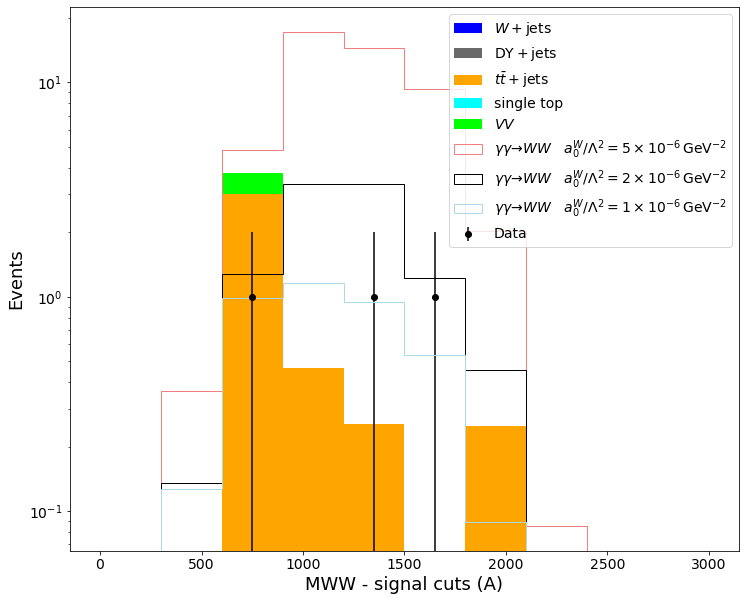

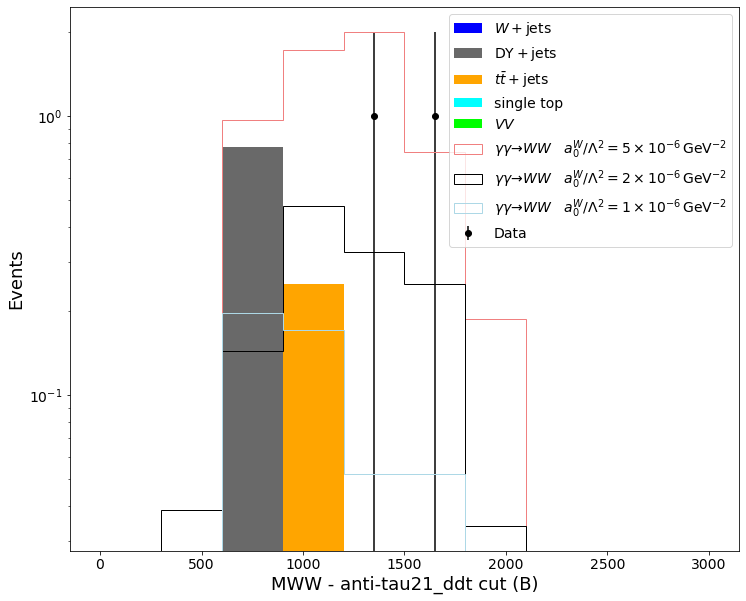

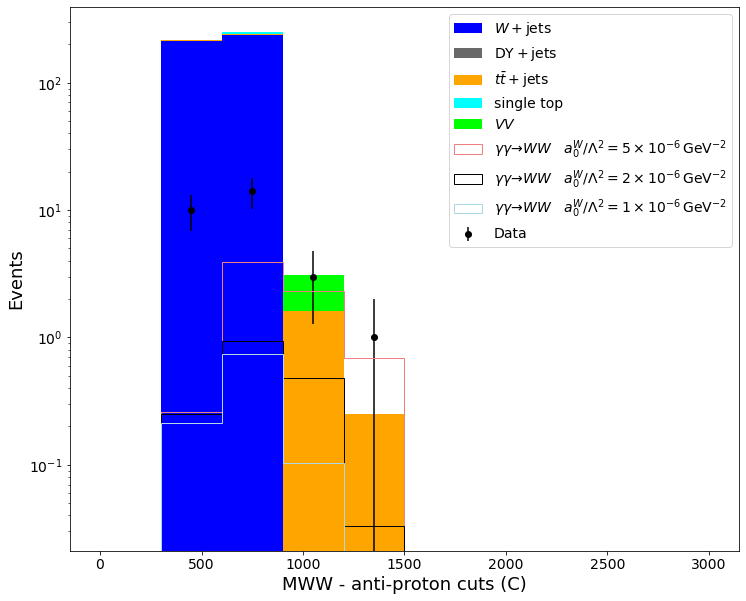

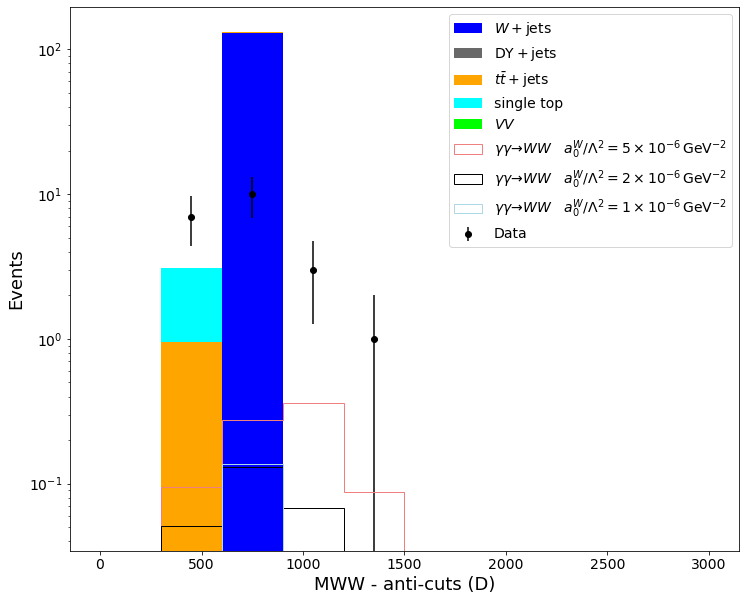

In [35]:
plot_var__ = "MWW"
variation__ = "_nom"

res_ = plot_sideband_tau21_ddt( plot_var=plot_var__, variation=variation__, df_bkg_events=df_protons_multiRP_bkg_events, df_data__=df_protons_multiRP_data_events )
n_events_bkg_A, err_n_events_bkg_A = res_[ 0 ]
n_events_bkg_B, err_n_events_bkg_B = res_[ 1 ]
n_events_bkg_C, err_n_events_bkg_C = res_[ 2 ]
n_events_bkg_D, err_n_events_bkg_D = res_[ 3 ]

In [32]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

def plot_sideband_prunedmass( plot_var, variation, df_bkg_events, df_data__ ):
    plot_var__ = plot_var
    variation__ = variation
    var1__ = ( "jet0_corrmass" + "_nom" ) 
    var2__ = ( "R_MWW_MX" + "_nom" )
    var3__ = ( "Diff_YWW_YX" + "_nom" )
    var4__ = ( "jet0_tau21_ddt" )
    
    arr_data_MC_mskA_ = []
    weights_data_MC_mskA_ = []
    arr_signal_mskA_ = []
    weights_signal__mskA_ = []
    
    arr_data_MC_mskB_ = []
    weights_data_MC_mskB_ = []
    arr_signal_mskB_ = []
    weights_signal__mskB_ = []
    
    arr_data_MC_mskC_ = []
    weights_data_MC_mskC_ = []
    arr_signal_mskC_ = []
    weights_signal__mskC_ = []
    
    arr_data_MC_mskD_ = []
    weights_data_MC_mskD_ = []
    arr_signal_mskD_ = []
    weights_signal__mskD_ = []
    
    colors_MC_ = []
    colors_sig_ = []
    labels_MC_ = []
    labels_sig_ = []
    
    colors_MC = [ "blue", "dimgray", "orange", "red", "cyan", "lime" ]
    colors_sig = [ "lightblue", "black", "lightcoral" ]

    linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]
    
    msk_data_cut1 = ( ( df_data__[ var1__ ] >= 50.0 ) & ( df_data__[ var1__ ] <= 110.0 ) )
    msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.80  ) & ( np.abs( df_data__[ var3__ ] ) <= 0.60 ) )
    msk_data_tau21 = (  df_data__[ var4__ ]  <= 0.7  )
    msk_data_A =  msk_data_cut1 &  msk_data_cut2 & msk_data_tau21
    msk_data_B = ~msk_data_cut1 &  msk_data_cut2 & msk_data_tau21
    msk_data_C =  msk_data_cut1 & ~msk_data_cut2 & msk_data_tau21
    msk_data_D = ~msk_data_cut1 & ~msk_data_cut2 & msk_data_tau21

    if not bkg_MC_mix_protons:
        df__ = df_bkg_events
    for idx__, label__ in enumerate( labels_bkg_plot ):
        if bkg_MC_mix_protons:
            df__ = df_bkg_events[ label__ ][ "_nom" ]          
        if df__.shape[0] > 0:
            msk_bkg_cut1 = ( ( df__[ var1__ ] >= 50.0 ) & ( df__[ var1__ ] <= 110.0 ) )
            msk_bkg_cut2 = ( ( df__[ var2__ ] >= 0.80  ) & ( np.abs( df__[ var3__ ] ) <= 0.60 ) )
            msk_bkg_tau21 = (  df__[ var4__ ]  <= 0.7  )
            msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_tau21
            msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_tau21
            msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_tau21
            msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_tau21
            
            weights__ = ( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )    
            
            if bkg_MC_mix_protons:
                arr_data_MC_mskA_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_A ] )
                weights_data_MC_mskA_.append( weights__[ msk_bkg_A ] )
                arr_data_MC_mskB_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_B ] )
                weights_data_MC_mskB_.append( weights__[ msk_bkg_B ] )
                arr_data_MC_mskC_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_C ] )
                weights_data_MC_mskC_.append( weights__[ msk_bkg_C ] )
                arr_data_MC_mskD_.append( df_bkg_events[ label__ ][ variation__ ][ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_D ] )
                weights_data_MC_mskD_.append( weights__[ msk_bkg_D ] )

            if not bkg_MC_mix_protons:
                arr_data_MC_mskC_.append( df_bkg_events[ plot_var__ + var_str__[ variation__ ] ] )
                weights_data_MC_mskC_.append( df_bkg_events[ "norm" ] )
                
            colors_MC_.append( colors_MC[ idx__ % len( colors_MC ) ] )
            labels_MC_.append( labels_samples_bkg[ label__ ] )
    
    n_events_bkg   = np.sum( weights__ )
    err_n_events_bkg = np.sqrt( np.sum( weights__ ** 2 ) )
    n_events_bkg_A = np.sum( weights__[ msk_bkg_A ] )
    err_n_events_bkg_A = np.sqrt( np.sum( weights__[ msk_bkg_A ] ** 2 ) )
    n_events_bkg_B = np.sum( weights__[ msk_bkg_B ] )
    err_n_events_bkg_B = np.sqrt( np.sum( weights__[ msk_bkg_B ] ** 2 ) )
    n_events_bkg_C = np.sum( weights__[ msk_bkg_C ] )
    err_n_events_bkg_C = np.sqrt( np.sum( weights__[ msk_bkg_C ] ** 2 ) )
    n_events_bkg_D = np.sum( weights__[ msk_bkg_D ] )
    err_n_events_bkg_D = np.sqrt( np.sum( weights__[ msk_bkg_D ] ** 2 ) )

    print ( "Number of bkg events: {} +/- {}".format( n_events_bkg, err_n_events_bkg ) )
    print ( "Number of bkg events (A): {} +/- {}".format( n_events_bkg_A, err_n_events_bkg_A ) )
    print ( "Number of bkg events (B): {} +/- {}".format( n_events_bkg_B, err_n_events_bkg_B ) )
    print ( "Number of bkg events (C): {} +/- {}".format( n_events_bkg_C, err_n_events_bkg_C ) )
    print ( "Number of bkg events (D): {} +/- {}".format( n_events_bkg_D, err_n_events_bkg_D ) )
    
    for idx__, label__ in enumerate( labels_signals ):
        df_signal__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
        
        msk_sig_cut1 = ( ( df_signal__[ var1__ ] >= 50.0 ) & ( df_signal__[ var1__ ] <= 110.0 ) )
        msk_sig_cut2 = ( ( df_signal__[ var2__ ] >= 0.80  ) & ( np.abs( df_signal__[ var3__ ] ) <= 0.60 ) )
        msk_sig_tau21 = (  df_signal__[ var4__ ]  <= 0.7  )
        msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2 & msk_sig_tau21
        msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2 & msk_sig_tau21
        msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_tau21
        msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_tau21  
        
        weights_sig__ = ( weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] )
        
        arr_signal_mskA_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_A ] )
        weights_signal__mskA_.append( weights_sig__[ msk_sig_A ] )
        arr_signal_mskB_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_B ] )
        weights_signal__mskB_.append( weights_sig__[ msk_sig_B ] )
        arr_signal_mskC_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_C ] )
        weights_signal__mskC_.append( weights_sig__[ msk_sig_C ] )
        arr_signal_mskD_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_D ] )
        weights_signal__mskD_.append( weights_sig__[ msk_sig_D ] )
        
        colors_sig_.append( colors_sig[ idx__ % len( colors_sig ) ] )
        labels_sig_.append( labels_samples[ label__ ] ) 
        
    n_events_sig   = np.sum( weights_sig__ )
    err_n_events_sig = np.sqrt( np.sum( weights_sig__ ** 2 ) )
    n_events_sig_A = np.sum( weights_sig__[ msk_sig_A ] )
    err_n_events_sig_A = np.sqrt( np.sum( weights_sig__[ msk_sig_A ] ** 2 ) )
    n_events_sig_B = np.sum( weights_sig__[ msk_sig_B ] )
    err_n_events_sig_B = np.sqrt( np.sum( weights_sig__[ msk_sig_B ] ** 2 ) )
    n_events_sig_C = np.sum( weights_sig__[ msk_sig_C ] )
    err_n_events_sig_C = np.sqrt( np.sum( weights_sig__[ msk_sig_C ] ** 2 ) )
    n_events_sig_D = np.sum( weights_sig__[ msk_sig_D ] )
    err_n_events_sig_D = np.sqrt( np.sum( weights_sig__[ msk_sig_D ] ** 2 ) )

    print ( "Number of signal events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of signal events (A): {} +/- {}".format( n_events_sig_A, err_n_events_sig_A ) )
    print ( "Number of signal events (B): {} +/- {}".format( n_events_sig_B, err_n_events_sig_B ) )
    print ( "Number of signal events (C): {} +/- {}".format( n_events_sig_C, err_n_events_sig_C ) )
    print ( "Number of signal events (D): {} +/- {}".format( n_events_sig_D, err_n_events_sig_D ) )
       
    x_min =  0.
    x_max =  3000.
    y_min = -5.0
    y_max =  5.0
    x_cut = 0.80
    y_cut = 0.60

    figA = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskA_, weights=weights_data_MC_mskA_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskA_, weights=weights_signal__mskA_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_A ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - signal cuts (A)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionA-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionA-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionA-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionA-Electron_2018.png", bbox_inches='tight' )
            
    figB = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskB_, weights=weights_data_MC_mskB_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskB_, weights=weights_signal__mskB_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_B ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - anti-prunedmass cut (B)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionB-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionB-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionB-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionB-Electron_2018.png", bbox_inches='tight' )
            
    figC = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskC_, weights=weights_data_MC_mskC_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskC_, weights=weights_signal__mskC_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_C ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - anti-proton cuts (C)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionC-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionC-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionC-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionC-Electron_2018.png", bbox_inches='tight' )    
            
    figD = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskD_, weights=weights_data_MC_mskD_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[0,3000], bins=10 )
    
    plt.hist( arr_signal_mskD_, weights=weights_signal__mskD_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[0,3000], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ] [ msk_data_D ], range=[0,3000], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    plt.yscale('log')
    
    plt.xlabel( plot_var__+" - anti-cuts (D)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionD-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionD-Muon_2018.png", bbox_inches='tight' )
        if lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionD-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-prunedmass-Sideband-RegionD-Electron_2018.png", bbox_inches='tight' )
            
    return ( ( n_events_bkg_A, err_n_events_bkg_A ), 
             ( n_events_bkg_B, err_n_events_bkg_B ), 
             ( n_events_bkg_C, err_n_events_bkg_C ), 
             ( n_events_bkg_D, err_n_events_bkg_D ),  
             ( n_events_sig_A, err_n_events_sig_A ),
             ( n_events_sig_B, err_n_events_sig_B ), 
             ( n_events_sig_C, err_n_events_sig_C ),
             ( n_events_sig_D, err_n_events_sig_D ) )

Number of bkg events: 246.16205091524841 +/- 240.8628543887653
Number of bkg events (A): 0.7834088063671798 +/- 0.7834088063671798
Number of bkg events (B): 0.0 +/- 0.0
Number of bkg events (C): 3.0662373218286043 +/- 1.533701630805871
Number of bkg events (D): 0.0 +/- 0.0
Number of signal events: 77.78786257665101 +/- 2.631231007397537
Number of signal events (A): 48.294404137662895 +/- 2.0721830896773
Number of signal events (B): 8.776679800015167 +/- 0.8803378629945912
Number of signal events (C): 7.163379579097865 +/- 0.7936911503666122
Number of signal events (D): 0.9124765926069394 +/- 0.2755981509077403


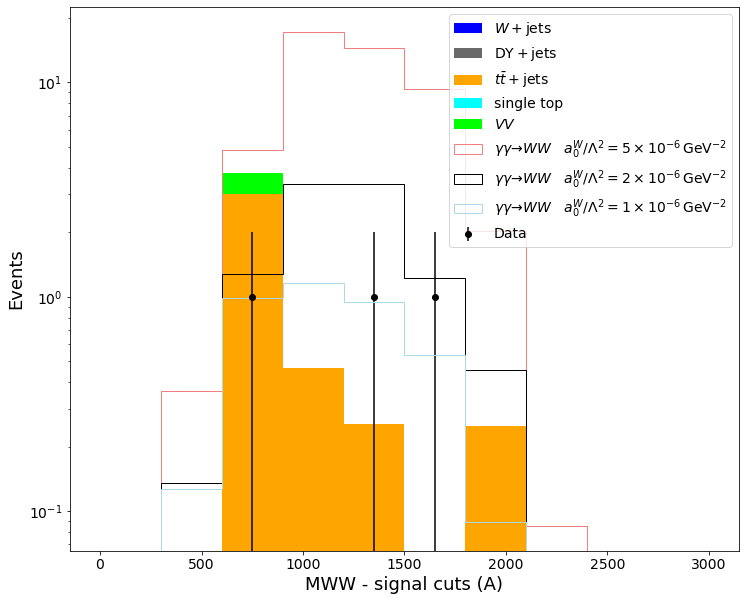

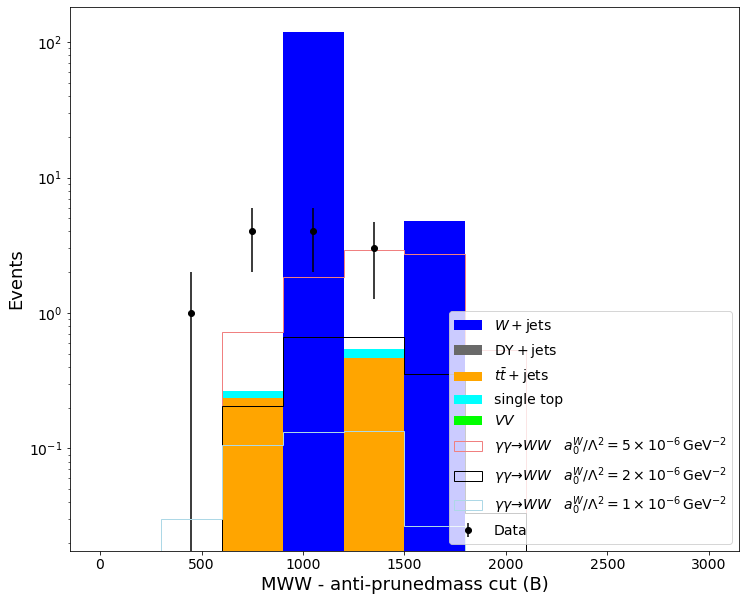

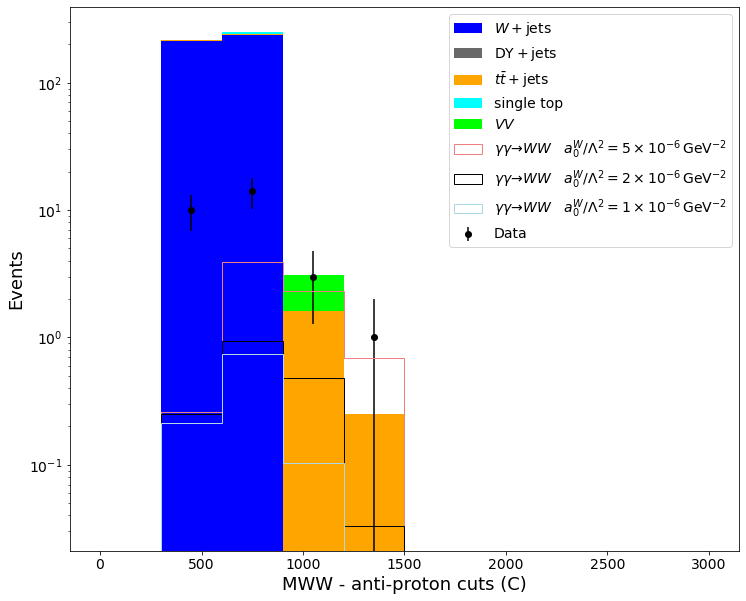

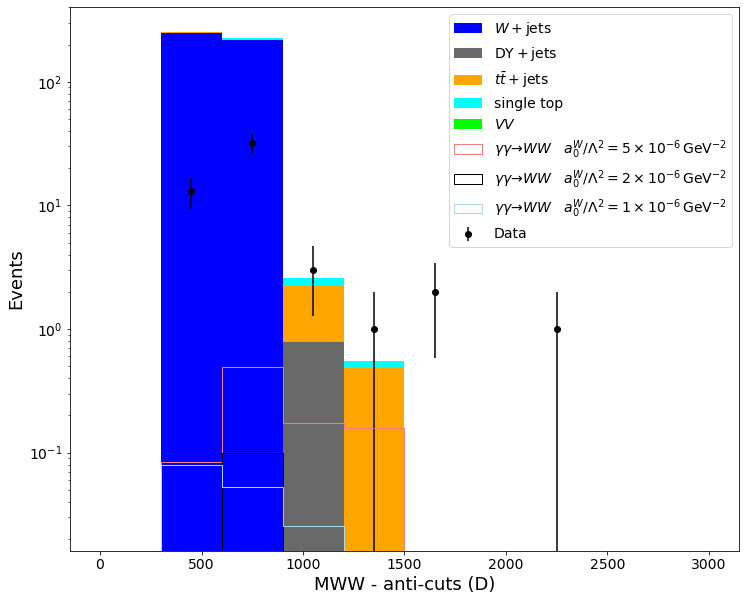

In [33]:
plot_var__ = "MWW"
variation__ = "_nom"

res_ = plot_sideband_prunedmass( plot_var=plot_var__, variation=variation__, df_bkg_events=df_protons_multiRP_bkg_events, df_data__=df_protons_multiRP_data_events )
n_events_bkg_A, err_n_events_bkg_A = res_[ 0 ]
n_events_bkg_B, err_n_events_bkg_B = res_[ 1 ]
n_events_bkg_C, err_n_events_bkg_C = res_[ 2 ]
n_events_bkg_D, err_n_events_bkg_D = res_[ 3 ]